In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from itertools import combinations
from sklearn.preprocessing import LabelEncoder

In [2]:
# process and standardize data
# This is not an all inclusive function....you should improve!
def preprocess_data(df):

    # Handle missing values by replacing '?' with NaN and dropping rows
    for col in df.columns:
        df[col] = df[col].replace('?', pd.NA)


    df = df.dropna()

    # Drop unnamed column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    # split off target early (if present)
    y = None
    if 'income' in df.columns:
        y = df['income']
        df = df.drop(columns=['income'])
    
    if y is not None:
        le = LabelEncoder()
        y = le.fit_transform(y).astype(int)  # encode target as int

    # detect numeric vs categorical by attempted coercion
    numeric_cols, categorical_cols = [], []
    for col in df.columns:
        coerced = pd.to_numeric(df[col], errors='coerce')
        if coerced.notna().all():
            df[col] = coerced.astype(float)   # numeric as float
            numeric_cols.append(col)
        else:
            df[col] = df[col].astype(str)     # categorical as string
            categorical_cols.append(col)
    
    # label-encode categoricals only
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col]).astype(int)  # encoded as int
        label_encoders[col] = le

    # standardize numeric columns only
    scaler = StandardScaler()
    if numeric_cols:
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols].astype(float)).astype(float)

    # Encode categorical features
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le


    # Make X and y dataframes
    X = pd.DataFrame(df).astype(float)
    if y is not None:
        y = pd.Series(y).astype(int)

    return X, y

In [3]:
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from itertools import combinations
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def plot_svm_decision_boundaries_multi_feature(X, y, kernels, title_prefix="", C=1.0, gamma='scale'):
    """
    Plots the decision boundaries for multiple SVM models and multiple feature pairs,
    automatically handling non-numerical target labels and different data types for y.

    Args:
        X (pd.DataFrame): The input features (must have at least 2 columns).
        y (pd.Series or np.ndarray or pd.DataFrame): The target labels.
        kernels (list): A list of kernel strings (e.g., 'linear', 'rbf', 'poly').
        title_prefix (str): A prefix for the plot titles.
        C (float): The regularization parameter.
        gamma (str or float): Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
    """
    # Standardize the y input to a pandas Series
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If 'y' is a DataFrame, it must contain a single column.")
        y_series = y.iloc[:, 0]
    elif isinstance(y, (pd.Series, np.ndarray)):
        # Convert to Series for consistent handling, and ravel to ensure 1D
        y_series = pd.Series(y).ravel()
    else:
        raise TypeError("y must be a pandas DataFrame, Series, or a NumPy array.")

    # Check the dtype of the uniform y_series and encode if necessary
    if y_series.dtype == 'object':
        print("Encoding string labels to numerical format...")
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = np.array(y_series)

    n_features = X.shape[1]
    if n_features < 2:
        raise ValueError("This function requires at least 2 features for plotting combinations.")

    feature_pairs = list(combinations(range(n_features), 2))
    n_pairs = len(feature_pairs)
    n_kernels = len(kernels)

    fig, axes = plt.subplots(n_kernels, n_pairs, figsize=(n_pairs * 6, n_kernels * 5),
                             constrained_layout=True)

    # Ensure axes is a 2D array even for a single row/column
    if n_kernels == 1 and n_pairs == 1:
        axes = np.array([[axes]])
    elif n_kernels == 1:
        axes = np.array([axes])
    elif n_pairs == 1:
        axes = axes.reshape(-1, 1)

    for i, kernel in enumerate(kernels):
        for j, (f1_idx, f2_idx) in enumerate(feature_pairs):
            ax = axes[i, j]

            # Select the two features for the current plot
            X_pair = X.iloc[:, [f1_idx, f2_idx]]
            f1_name = X.columns[f1_idx]
            f2_name = X.columns[f2_idx]

            # Train the SVM model on the selected features
            if kernel == 'poly':
                model = SVC(kernel=kernel, C=C, gamma=gamma, degree=3)
            else:
                model = SVC(kernel=kernel, C=C, gamma=gamma)
            
            # FIT THE MODEL WITH .values TO AVOID THE WARNING
            model.fit(X_pair.values, y_encoded)

            # Plot the data points with encoded labels
            ax.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y_encoded, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

            # Create and plot the decision boundary
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                                 np.linspace(ylim[0], ylim[1], 500))
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
            
            # Highlight the support vectors
            ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
                       linewidth=1, facecolors='none', edgecolors='k')
            
            # Set titles and labels
            ax.set_title(f"{title_prefix} {kernel.capitalize()} ({f1_name} vs {f2_name})")
            ax.set_xlabel(f1_name)
            ax.set_ylabel(f2_name)
            ax.set_aspect('equal', adjustable='box')

    plt.show()

In [5]:
df = pd.read_csv('Data/project_adult.csv', encoding='utf-8')

X, y = preprocess_data(df)

In [6]:
# split data into training and test datasets
# can specify same proportion of classes in both sets with stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [7]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Pick an amount of row positions
n = len(X_train)
k = max(1, int(n))
pos_idx = np.random.default_rng(42).choice(n, size=k, replace=False)

# Slice both X and y by position so indices always align
X_sample = X_train.iloc[pos_idx]
y_sample = y_train.iloc[pos_idx] if hasattr(y_train, "iloc") else np.take(y_train, pos_idx)

param_grid = {
    'C': [0.01, 1, 100],
    'kernel': ['linear','rbf', 'poly'],      # keep small while testing
    'gamma': ['scale']
}

grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Starting hyperparameter search with a 50% sample...")
grid_search.fit(X_sample, np.ravel(y_sample))

Starting hyperparameter search with a 50% sample...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 1, 100], 'gamma': ['scale'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)


--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8372

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8386

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4538
           1       0.75      0.52      0.62      1502

    accuracy                           0.84      6040
   macro avg       0.81      0.73      0.76      6040
weighted avg       0.83      0.84      0.83      6040


Confusion Matrix:
[[4284  254]
 [ 721  781]]


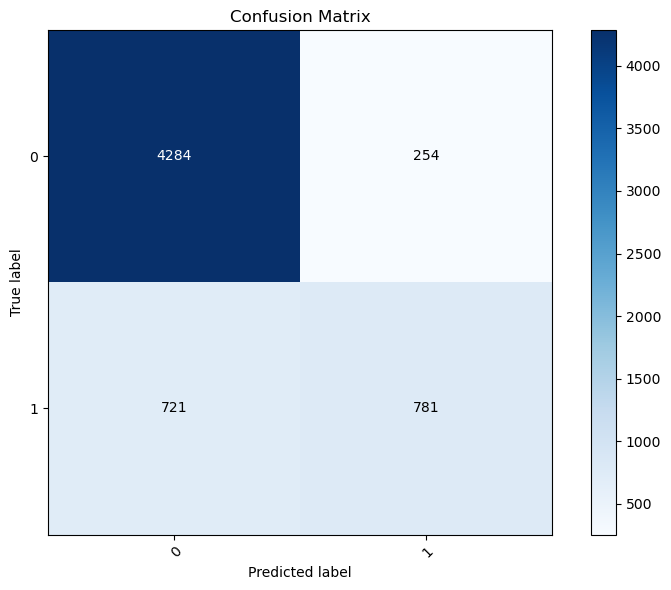

In [8]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

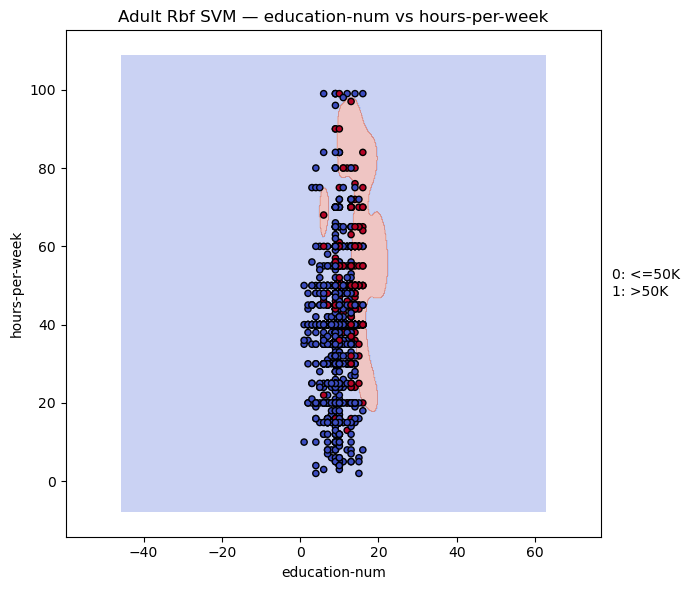

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def plot_svm_decision_boundary_two_features(df, y_col, f1, f2, kernel='rbf', C=1.0, gamma='scale', degree=3, title_prefix=""):
    """
    Plots an SVM decision boundary for exactly two numeric features.

    Args:
        df (pd.DataFrame): Data containing features and target.
        y_col (str): Name of the target column.
        f1, f2 (str): Names of the two numeric feature columns to plot.
        kernel (str): 'linear', 'rbf', 'poly', or 'sigmoid'.
        C (float): Regularization parameter.
        gamma (str or float): Kernel coefficient for 'rbf', 'poly', 'sigmoid'.
        degree (int): Degree for polynomial kernel when kernel='poly'.
        title_prefix (str): Optional prefix for plot title.
    """
    # Select features and drop rows with missing values in features/target
    X_pair = df[[f1, f2]].copy()
    y_raw = df[y_col]
    mask = X_pair.notna().all(axis=1) & y_raw.notna()
    X_pair = X_pair.loc[mask]
    y_raw = y_raw.loc[mask]

    # Encode string labels if needed
    if y_raw.dtype == 'object' or str(y_raw.dtype).startswith('category'):
        le = LabelEncoder()
        y = le.fit_transform(y_raw.astype(str))
        target_names = list(le.classes_)
    else:
        y = y_raw.to_numpy()
        target_names = None

    # Build the model (standardize for better-behaved margins)
    if kernel == 'poly':
        model = make_pipeline(StandardScaler(), SVC(kernel=kernel, C=C, gamma=gamma, degree=degree))
    else:
        model = make_pipeline(StandardScaler(), SVC(kernel=kernel, C=C, gamma=gamma))

    # Fit on the two features
    model.fit(X_pair.values, y)

    # Create a dense grid over the feature space
    x_min, x_max = X_pair[f1].min(), X_pair[f1].max()
    y_min, y_max = X_pair[f2].min(), X_pair[f2].max()
    pad_x = 0.05 * (x_max - x_min if x_max > x_min else 1.0)
    pad_y = 0.05 * (y_max - y_min if y_max > y_min else 1.0)

    # Force equal span on both axes
    span = max((x_max - x_min) + 2*pad_x, (y_max - y_min) + 2*pad_y)
    mid_x = (x_min + x_max) / 2
    mid_y = (y_min + y_max) / 2

    x_min, x_max = mid_x - span/2, mid_x + span/2
    y_min, y_max = mid_y - span/2, mid_y + span/2

    xx, yy = np.meshgrid(
        np.linspace(x_min - pad_x, x_max + pad_x, 500),
        np.linspace(y_min - pad_y, y_max + pad_y, 500)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plot data and boundary
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.contourf(xx, yy, Z, alpha=0.30, cmap=plt.cm.coolwarm)

    # Scatter points; c=y displays encoded classes
    ax.scatter(X_pair[f1], X_pair[f2], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

    title_core = f"{kernel.capitalize()} SVM — {f1} vs {f2}"
    ax.set_title(f"{title_prefix} {title_core}".strip())
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_aspect('equal', adjustable='box')

    # Legend for classes if label encoder was used
    if target_names is not None and len(np.unique(y)) <= 10:
        # Create a simple legend mapping colors to class names
        # Note: exact colors come from colormap; this gives a compact textual legend instead.
        uniq = np.unique(y)
        legend_labels = [f"{cls_idx}: {target_names[cls_idx]}" for cls_idx in uniq]
        ax.text(1.02, 0.5, "\n".join(legend_labels), transform=ax.transAxes, va='center')
    ax.set_aspect('equal', adjustable='datalim')  # ensures axes are equal scale

    plt.tight_layout()
    plt.show()


# =========================
# Usage
# =========================
df2 = df.sample(frac = 0.10, random_state=42)  # smaller sample for faster plotting
plot_svm_decision_boundary_two_features(
    df=df2,
    y_col="income",                 # target column in this dataset
    f1="education-num",             # recommended feature 1
    f2="hours-per-week",            # recommended feature 2
    kernel="rbf",
    C=100.0,
    gamma="scale",
    title_prefix="Adult"
)

In [10]:
valid_df = pd.read_csv("Data/project_validation_inputs.csv", encoding='utf-8')

X_valid, y_valid = preprocess_data(valid_df)

# Make predictions on the validation set using the best model found during the search.
valid_y_pred = best_model.predict(X_valid)

df_valid = pd.DataFrame(valid_y_pred, columns=['Predicted_Income'])

# Save to a df and upload to a CSV
df_valid.to_csv("Data/validation_predictions/Group_8_SVM_PredictedOutputs.csv")